In [128]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo
from scipy import signal

def wave(t,*pars):
    amp,t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*amp*(np.exp(-(t-t0).astype(float)/tau1)-np.exp(-(t-t0).astype(float)/tau2))

fac=1

def linearCombine(a1,b1):# (N,*pars):
    N=pretrigger
    t=np.arange(N,dtype=float)
    v=np.zeros((7,N),dtype=float) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*fac*t)
    v[1,0:N]=b1*np.cos(w*fac*t)
    #v[2,0:N]=a2*np.sin(w/2.*t)
    #v[3,0:N]=b2*np.cos(w/2.*t)
    #v[4,0:N]=c*wave(t,1,t0,tau,rise)
    return np.sum(v,axis=0)

def full_wave(a1,b1):
    N=length
    t=np.arange(N,dtype=float)
    v=np.zeros((7,N),dtype=float) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*fac*t)
    v[1,0:N]=b1*np.cos(w*fac*t)
    #v[2,0:N]=a2*np.sin(w/2.*t)
    #v[3,0:N]=b2*np.cos(w/2.*t)
    #v[4,0:N]=c*wave(t,1,t0,tau,rise)
    return np.sum(v,axis=0)


means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])
run='/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin';name=run[-13:-6]
#run='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/Run_0_0.bin';name=run[-11:-6];means=np.ones(48,dtype='float')*1250
numwaves=int((os.stat(run).st_size-8)/7033)
print(numwaves)
data=fr.raw(run,length=3500,row=0,numwaves=numwaves)
wo.baseline_restore(data,600)

429600


In [129]:
fs=35
bd,ch=1,3
pretrigger=900
length=3500
rise,top=400,70
length=len(data['wave'][0])
amps=np.zeros((len(data),4))
DesignT=np.array([linearCombine(1,0), \
                   linearCombine(0,1)])
Cov=np.linalg.inv(np.matmul(DesignT,DesignT.T))
t=np.arange(length)
traps=np.zeros((48,length))
wo.multi_trap(arr=traps,rise=rise,top=top)
out=np.zeros(length)
parray=np.zeros((len(data),9))   #two amp pars, two SE's, s^2, two trap outputs,bin min, binmax
trap=np.array([np.zeros(length)])

N=6
e=[0]
for i in range(len(data)):
    bd,ch=data['board'][i],data['channel'][i]
    bdch=8*bd+ch
    trap[0,0:length]=signal.convolve(data['wave'][i][0:length],traps[bdch,0:length])[0:length]
    wo.trap_energy(traps=trap,length=length,output=e)
    parray[i,5]=e[0]
    parray[i,0:2]=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
                        DesignT),data['wave'][i,0:pretrigger])
    trap[0,0:length]=signal.convolve(data['wave'][i][0:length]-full_wave(parray[i,0],parray[i,1]),\
                                     traps[bdch,0:length])[0:length]
    wo.trap_energy(traps=trap,length=length,output=e)
    parray[i,6]=e[0]
    yhat=np.matmul(DesignT.T,parray[i,0:2])
    yhat=data['wave'][i,0:pretrigger]-yhat
    s2=np.matmul(yhat.T,yhat)/(pretrigger-DesignT.shape[0])
    parray[i,4]=s2
#    print(s2)
    Cov=np.linalg.inv(np.matmul(DesignT,DesignT.T))  #Now DesignT is the covariance matrix
#    print('Amplitude        +/- Standard Dev \n ---------------------------------------')
    parray[i,2:4]=np.sqrt(s2*np.diag(Cov))
    parray[i,7]=np.argmin(full_wave(parray[i,0],parray[i,1]))
    parray[i,8]=np.argmax(full_wave(parray[i,0],parray[i,1]))
#    for j in range(len(sterrors)):
#        print(str(parray[i,j])+' +/- '+str(parray[i,2+j]) )
#    cov=s2*DesignT
#    print('\nCovariance Matrix \n ------------------------')
#    print(cov)
#    sigmas=np.sqrt(np.diag(cov))
#    print('\n X^2/DoF               Sigma        \n ----------------------------')
#    print(s2,'|',np.sqrt(s2))
    
    
    #STUFF IS BEING STORED IN PARRAY!!!!
    plot=False
    if parray[i,7]<2000 and plot==True and np.abs(parray[i,0])>10: #np.sum(np.sqrt(parray[i,0]**2.))>20
        print (parray[i,5:9])
        p=parray[i,0:2]
        pretrigger=3500
        plt.figure(figsize=(30,20))
        plt.plot(t,data['wave'][i])
        plt.plot(t,trap[0],label='trap')
        #plt.plot(t[0:len(yhat)],yhat,'ro',label='residuals')
        plt.plot(t,linearCombine(*p),label='fit')
        #plt.plot(t,linearCombine(p[0],0), label=r'sin(${0:0.2f}\omega t)$'.format(fac))
        #plt.plot(t,linearCombine(0,p[1]), label=r'cos(${0:0.2f}\omega t)$'.format(fac))
        plt.plot(t,parray[i,5]*np.ones(length),'r--',label='unadjusted energy')
        plt.plot(t,parray[i,6]*np.ones(length),'b--',label='adjusted energy')
        plt.tick_params(labelsize=fs)
        plt.legend(fontsize=fs)
        plt.show()
        break

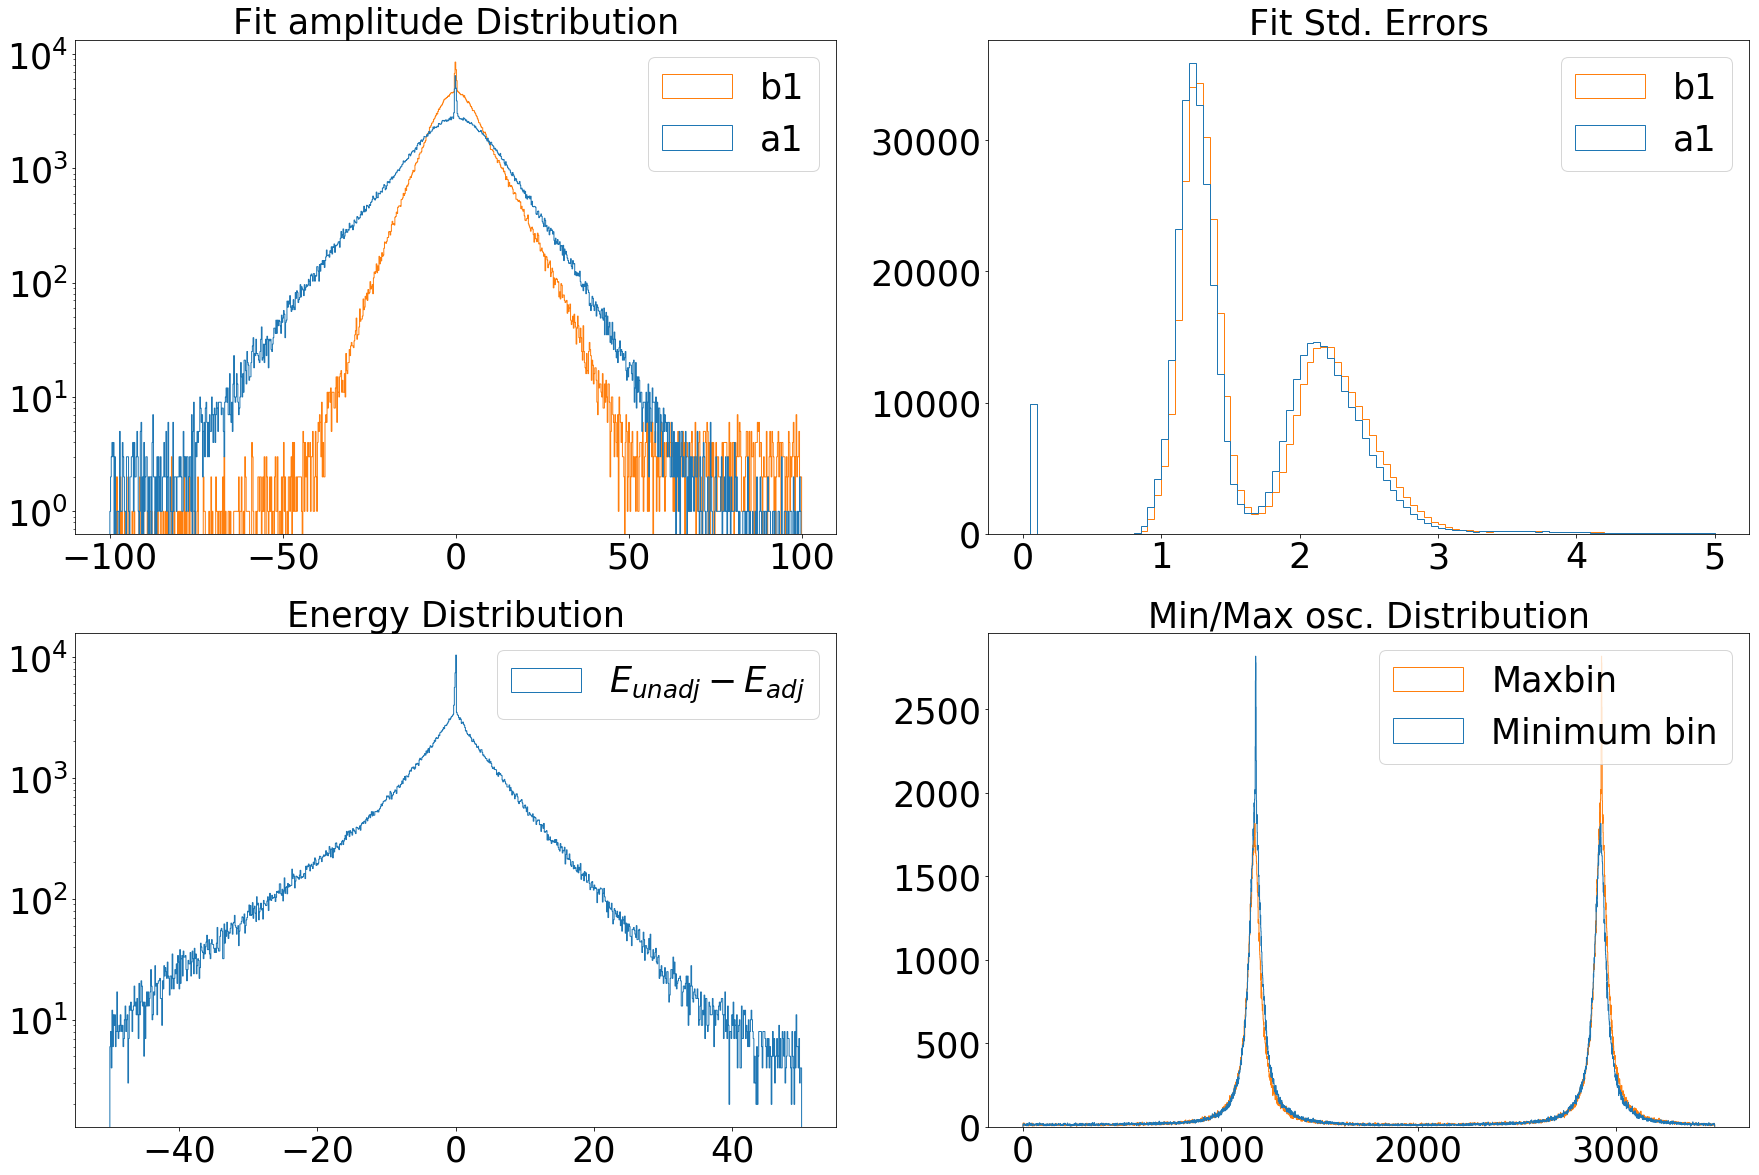

In [130]:
fs=35
phi=np.arctan(parray[:,1]/parray[:,0])
fig,ax=plt.subplots(2, 2,figsize=(30,20))
ax[0,0].set_title('Fit amplitude Distribution',fontsize=fs)
ax[0,0].hist(parray[:,0:2],bins=1000,range=[-100,100],histtype='step',label=['a1','b1'])
ax[0,1].set_title('Fit Std. Errors',fontsize=fs)
ax[0,1].hist(parray[:,2:4],bins=100,range=[0,5],histtype='step',label=['a1','b1'])
ax[1,0].set_title(r'Energy Distribution',fontsize=fs)
ax[1,0].hist(parray[:,5]-parray[:,6],bins=1000,range=[-50,50],histtype='step',label=[r'$E_{unadj} - E_{adj}$','Adjusted E'])
ax[1,0].set_yscale('log')
#ax[1,0].set_xlim((66,3500))
ax[1,1].set_title(r'Min/Max osc. Distribution',fontsize=fs)
ax[1,1].hist(parray[:,7:9],bins=3500,range=[0,3500],histtype='step',label=['Minimum bin','Maxbin'])#[r'$\frac{\chi^2}{DoF}$')
ax[0,0].set_yscale('log')
for item in ax.flatten():
    item.tick_params(labelsize=fs)
    item.legend(fontsize=fs)
plt.savefig('tmp-'+name+'.pdf',fmt='pdf')
plt.show()